In [4]:
#conversion of publisheAt column to dat and time format..


import pandas as pd

# Input CSV path (original dataset)
input_path = "/kaggle/input/shorts-csv/shorts_daily_stats.csv"

# Output CSV path (enriched dataset)
output_path = "/kaggle/working/shorts_metadata_with_time.csv"

# Load dataset
df = pd.read_csv(input_path)

# Ensure publishedAt is datetime format
df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')

# Create new columns
df['publish_hour'] = df['publishedAt'].dt.hour       # Extract hour (0-23)
df['publish_day'] = df['publishedAt'].dt.dayofweek   # Extract day of week (0=Mon, 6=Sun)

# Save updated dataset
df.to_csv(output_path, index=False)

print("✅ New dataset saved at:", output_path)
print(df[['videoId', 'publishedAt', 'publish_hour', 'publish_day']].head())
















✅ New dataset saved at: /kaggle/working/shorts_metadata_with_time.csv
       videoId               publishedAt  publish_hour  publish_day
0  e5onzptQghg 2025-10-02 16:01:07+00:00            16            3
1  qPSqowMfAaE 2025-10-02 04:01:05+00:00             4            3
2  BxOrnFtdKGM 2025-09-30 23:00:23+00:00            23            1
3  bK2k68Wab-A 2025-09-29 13:01:12+00:00            13            0
4  vApNbHuqkhg 2025-09-26 04:01:24+00:00             4            4


In [6]:
#normalising values by calculating the ratio; likeratio, commentratio and engagementratio..

import pandas as pd

# Load the dataset with publish_hour & publish_day
input_path = "/kaggle/working/shorts_metadata_with_time.csv"
output_path = input_path

df = pd.read_csv(input_path)

# Avoid division by zero (only calculate ratios where views > 0)
df['like_ratio'] = df.apply(lambda x: x['likeCount']/x['viewCount'] if x['viewCount'] > 0 else 0, axis=1)
df['comment_ratio'] = df.apply(lambda x: x['commentCount']/x['viewCount'] if x['viewCount'] > 0 else 0, axis=1)
df['engagement_score'] = df.apply(lambda x: (x['likeCount'] + x['commentCount'])/x['viewCount'] if x['viewCount'] > 0 else 0, axis=1)

# Save updated dataset
df.to_csv(output_path, index=False)

print("✅ Engagement metrics added. New dataset saved at:", output_path)
print(df[['videoId', 'viewCount', 'likeCount', 'commentCount', 'like_ratio', 'comment_ratio', 'engagement_score']].head())


✅ Engagement metrics added. New dataset saved at: /kaggle/working/shorts_metadata_with_time.csv
       videoId  viewCount  likeCount  commentCount  like_ratio  comment_ratio  \
0  e5onzptQghg       1328         21             1    0.015813       0.000753   
1  qPSqowMfAaE      26283        389            18    0.014800       0.000685   
2  BxOrnFtdKGM       3621         96             4    0.026512       0.001105   
3  bK2k68Wab-A      15899        111            58    0.006982       0.003648   
4  vApNbHuqkhg      10246        184            13    0.017958       0.001269   

   engagement_score  
0          0.016566  
1          0.015485  
2          0.027617  
3          0.010630  
4          0.019227  


Preprocessed dataset saved at: /kaggle/working/shorts_metadata_preprocessed.csv


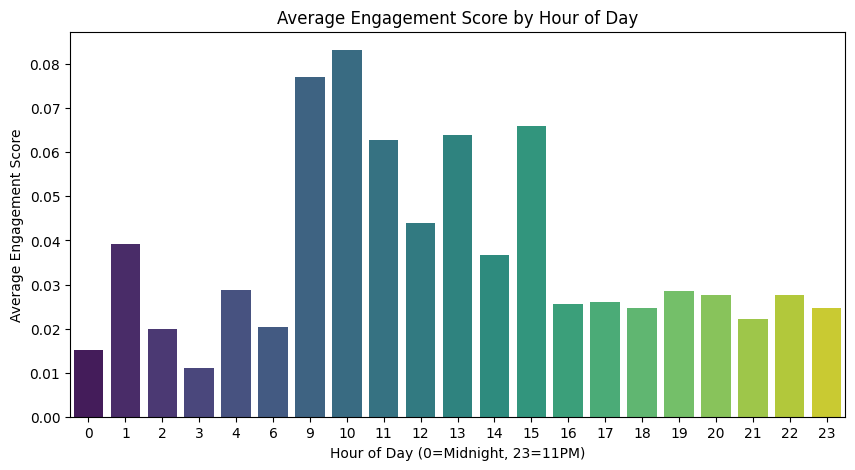

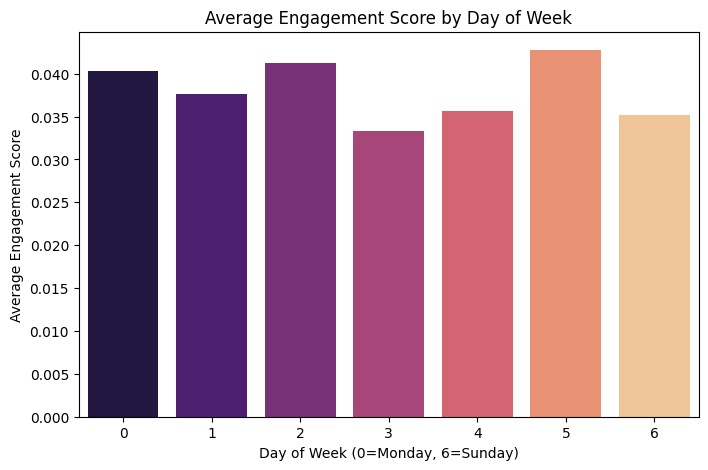

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


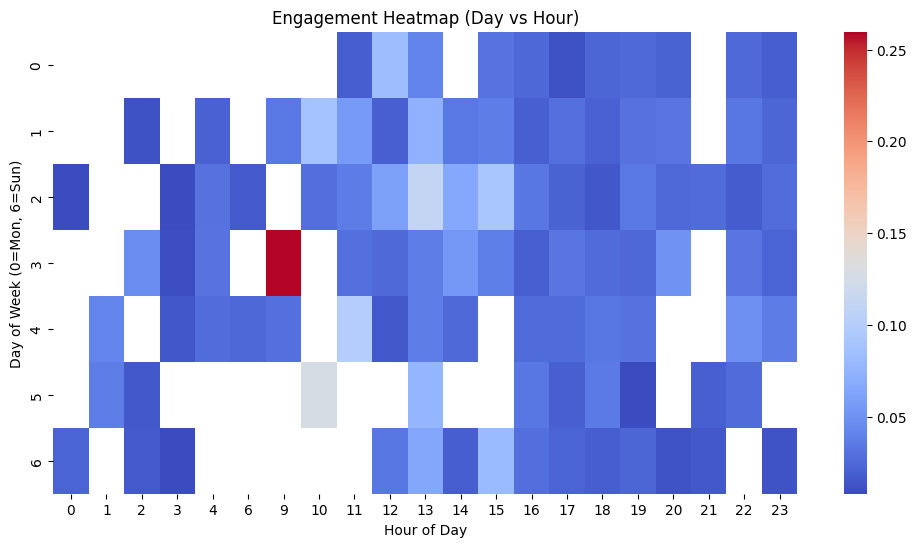

In [3]:
#Analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Step 1: Load dataset
# -------------------------
input_path = "/kaggle/input/changed-dataset1/shorts_metadata_with_time (1).csv"
df = pd.read_csv(input_path)


# -------------------------
# Step 3: Save new dataset (without overwriting original)
# -------------------------
output_path = "/kaggle/working/shorts_metadata_preprocessed.csv"
df.to_csv(output_path, index=False)
print(f"Preprocessed dataset saved at: {output_path}")

# -------------------------
# Step 4: Analysis & Visualization
# -------------------------
# Average engagement by HOUR
hourly_engagement = df.groupby("publish_hour")["engagement_score"].mean().reset_index()

# Average engagement by DAY
daily_engagement = df.groupby("publish_day")["engagement_score"].mean().reset_index()

# Matrix for Heatmap (Day × Hour)
heatmap_data = df.groupby(["publish_day", "publish_hour"])["engagement_score"].mean().unstack()

# Bar Plot: Hourly engagement
plt.figure(figsize=(10,5))
sns.barplot(data=hourly_engagement, x="publish_hour", y="engagement_score", palette="viridis")
plt.title("Average Engagement Score by Hour of Day")
plt.xlabel("Hour of Day (0=Midnight, 23=11PM)")
plt.ylabel("Average Engagement Score")
plt.show()

# Bar Plot: Daily engagement
plt.figure(figsize=(8,5))
sns.barplot(data=daily_engagement, x="publish_day", y="engagement_score", palette="magma")
plt.title("Average Engagement Score by Day of Week")
plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Average Engagement Score")
plt.show()

# Heatmap: Day × Hour
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, cbar=True)
plt.title("Engagement Heatmap (Day vs Hour)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (0=Mon, 6=Sun)")
plt.show()


In [3]:
#Preprocessing for ml model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -------------------------
# Step 1: Load dataset
# -------------------------
input_path = "/kaggle/input/changedcsv2/shorts_metadata_preprocessed.csv"
df = pd.read_csv(input_path)

# -------------------------
# Step 2: Preprocessing
# -------------------------

# Create title_length feature
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()))

# Create target variable (High vs Low Engagement)
threshold = df['engagement_score'].median()
df['high_engagement'] = (df['engagement_score'] >= threshold).astype(int)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['publish_hour', 'publish_day'], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['title_length', 'like_ratio', 'comment_ratio']
df[num_cols] = scaler.fit_transform(df[num_cols])

# -------------------------
# Step 3: Train/Test Split
# -------------------------
X = df.drop(['videoId', 'title', 'publishedAt', 'engagement_score', 'high_engagement'], axis=1)
y = df['high_engagement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------
# Step 4: Save Train/Test Datasets
# -------------------------
X_train.to_csv("/kaggle/working/X_train.csv", index=False)
X_test.to_csv("/kaggle/working/X_test.csv", index=False)
y_train.to_csv("/kaggle/working/y_train.csv", index=False)
y_test.to_csv("/kaggle/working/y_test.csv", index=False)

print("Train and Test datasets saved successfully!")


Train and Test datasets saved successfully!


In [7]:
import pandas as pd

# Load CSVs
X_train = pd.read_csv("/kaggle/working/X_train.csv")
X_test = pd.read_csv("/kaggle/working/X_test.csv")

# Check data types
print("X_train dtypes:")
print(X_train.dtypes)
print("\nSample values:")
print(X_train.head())

# Check unique values of all object/bool columns
for col in X_train.columns:
    if X_train[col].dtype == object or X_train[col].dtype == bool:
        print(f"{col} unique values: {X_train[col].unique()}")


X_train dtypes:
viewCount            int64
likeCount            int64
commentCount         int64
fetchDate           object
like_ratio         float64
comment_ratio      float64
title_length       float64
publish_hour_1        bool
publish_hour_2        bool
publish_hour_3        bool
publish_hour_4        bool
publish_hour_6        bool
publish_hour_9        bool
publish_hour_10       bool
publish_hour_11       bool
publish_hour_12       bool
publish_hour_13       bool
publish_hour_14       bool
publish_hour_15       bool
publish_hour_16       bool
publish_hour_17       bool
publish_hour_18       bool
publish_hour_19       bool
publish_hour_20       bool
publish_hour_21       bool
publish_hour_22       bool
publish_hour_23       bool
publish_day_1         bool
publish_day_2         bool
publish_day_3         bool
publish_day_4         bool
publish_day_5         bool
publish_day_6         bool
dtype: object

Sample values:
   viewCount  likeCount  commentCount   fetchDate  like_ratio  

In [8]:
#solving error
import pandas as pd

# -------------------------
# Load X datasets
# -------------------------
X_train = pd.read_csv("/kaggle/working/X_train.csv")
X_test = pd.read_csv("/kaggle/working/X_test.csv")

# -------------------------
# Convert boolean columns to 0/1
# -------------------------
for col in X_train.select_dtypes(include=['bool']).columns:
    X_train[col] = X_train[col].astype(int)

for col in X_test.select_dtypes(include=['bool']).columns:
    X_test[col] = X_test[col].astype(int)

# -------------------------
# Save changes back to SAME CSVs
# -------------------------
X_train.to_csv("/kaggle/working/X_train.csv", index=False)
X_test.to_csv("/kaggle/working/X_test.csv", index=False)

print("✅ Converted all boolean columns to 0/1 in X_train and X_test!")


✅ Converted all boolean columns to 0/1 in X_train and X_test!


In [10]:
#Training and testing of Logistic regression model
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# -------------------------
# Step 1: Load Train/Test Data
# -------------------------
X_train = pd.read_csv("/kaggle/working/X_train.csv")
X_test = pd.read_csv("/kaggle/working/X_test.csv")
y_train = pd.read_csv("/kaggle/working/y_train.csv").squeeze()  # squeeze() → makes it Series
y_test = pd.read_csv("/kaggle/working/y_test.csv").squeeze()
if 'fetchDate' in X_train.columns:
    X_train = X_train.drop('fetchDate', axis=1)
if 'fetchDate' in X_test.columns:
    X_test = X_test.drop('fetchDate', axis=1)

# -------------------------
# Step 2: Train Logistic Regression Model
# -------------------------
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# -------------------------
# Step 3: Predictions
# -------------------------
y_pred = log_reg.predict(X_test)

# -------------------------
# Step 4: Model Evaluation
# -------------------------
print("✅ Logistic Regression Model Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -------------------------
# Step 5: Save the Model
# -------------------------
model_path = "/kaggle/working/logistic_regression_model.pkl"
joblib.dump(log_reg, model_path)
print(f"✅ Model saved at: {model_path}")


✅ Logistic Regression Model Evaluation
Accuracy: 0.9444444444444444

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        36
           1       1.00      0.89      0.94        36

    accuracy                           0.94        72
   macro avg       0.95      0.94      0.94        72
weighted avg       0.95      0.94      0.94        72


Confusion Matrix:
 [[36  0]
 [ 4 32]]
✅ Model saved at: /kaggle/working/logistic_regression_model.pkl
